In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('..')

In [3]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from data_loading import get_movielens_data
from evaluation import evaluate_policy
from policies.bcmab_rp import BCMAB_RP
from policies.cbrap import CBRAP
from policies.linucb import LinUCB
from policies.linear_ts import LinearTS
from policies.d_lin_ts import DLinTS
from policies.random import RandomPolicy
from policies.egreedy import EGreedy
from reduct_matrix import get_reduct_matrix

from sklearn.model_selection import train_test_split

In [4]:
# Reproducibility
seed = 42
np.random.seed(seed)

In [5]:
dataset = get_movielens_data()

In [6]:
red_dim = 24
reduct_matrix = get_reduct_matrix("movielens", red_dim, load_old_reduct_matrix=True)

In [7]:
times = 100000

### Define policies

In [8]:
total_start_ts = time.time()

#### Introduce nonstationarity

In [9]:
CHAGNE_POINTS = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 100000]

In [10]:
def evaluation_nonstationarity_function(trial, arm, num_of_arms):
    """Takes trial and arm index as input and returns index of arm with which to swap."""
    N_ARMS = num_of_arms
    SHIFT_SIZE = int(0.4 * N_ARMS)

    intervals = [1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 100000]
    assert intervals == CHAGNE_POINTS
    for i, (start, end) in enumerate(zip(intervals, intervals[1:])):
        if start <= trial < end:
            return (arm + i * SHIFT_SIZE) % N_ARMS
    return arm


def tuning_nonstationarity_function(trial, arm, num_of_arms):
    """Takes trial and arm index as input and returns index of arm with which to swap."""
    N_ARMS = num_of_arms
    SHIFT_SIZE = int(0.4 * N_ARMS)
    intervals = [1, 10000, 20000, 30000]
    assert intervals == CHAGNE_POINTS
    for i, (start, end) in enumerate(zip(intervals, intervals[1:])):
        if start <= trial < end:
            return (arm + i * SHIFT_SIZE) % N_ARMS
    return arm


#### Check nonstationarity

In [11]:
reward_vecs = np.zeros((times, 1000))
users = dataset.generate_users(times, tune=False)

for i, user_data in enumerate(users):
    context, reward_vector, score_true, missing_vector = user_data
    reward_vecs[i, :] = reward_vector

First user in exp from 2008-10-29 03:36:53
Last user in exp from 2009-01-05 05:52:22


In [12]:
nonst_reward_vecs = np.zeros(reward_vecs.shape)
for t in range(reward_vecs.shape[0]):
    for a in range(reward_vecs.shape[1]):
        nonst_reward_vecs[t, a] = reward_vecs[t, evaluation_nonstationarity_function(t, a, 1000)]

In [13]:
reward_vecs

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.]])

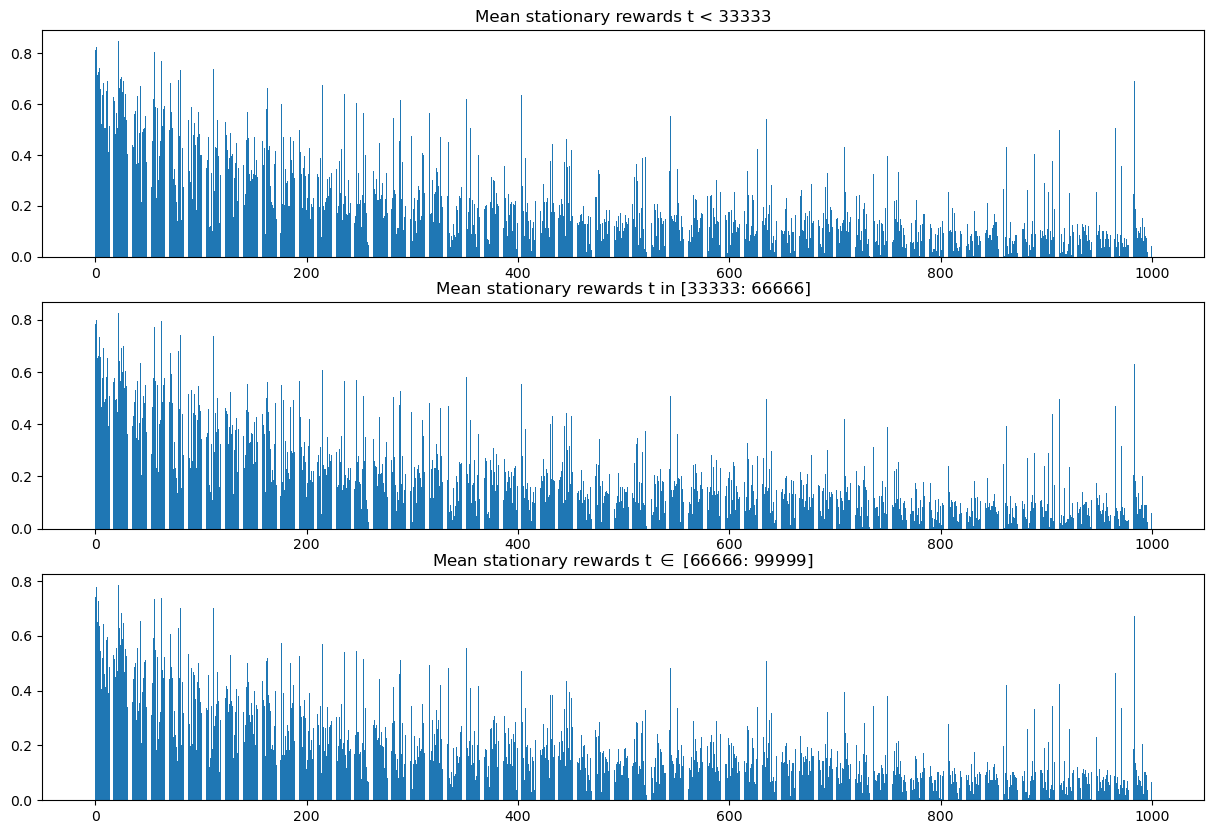

In [14]:
fig, axs = plt.subplots(3,1, figsize=(15, 10))
axs[0].bar(list(range(1000,)), np.mean(reward_vecs[:int(times/3)], axis=0))
axs[0].set_title(f'Mean stationary rewards t < {int(times/3)}')

axs[1].bar(list(range(1000,)), np.mean(reward_vecs[int(times/3):2*(int(times/3))], axis=0))
axs[1].set_title(fr'Mean stationary rewards t in [{int(times/3)}: {2*int(times/3)}]')

axs[2].bar(list(range(1000,)), np.mean(reward_vecs[2*(int(times/3)): 3*(int(times/3))], axis=0))
axs[2].set_title(fr'Mean stationary rewards t $\in$ [{2* int(times/3)}: {3*int(times/3)}]')
plt.show()

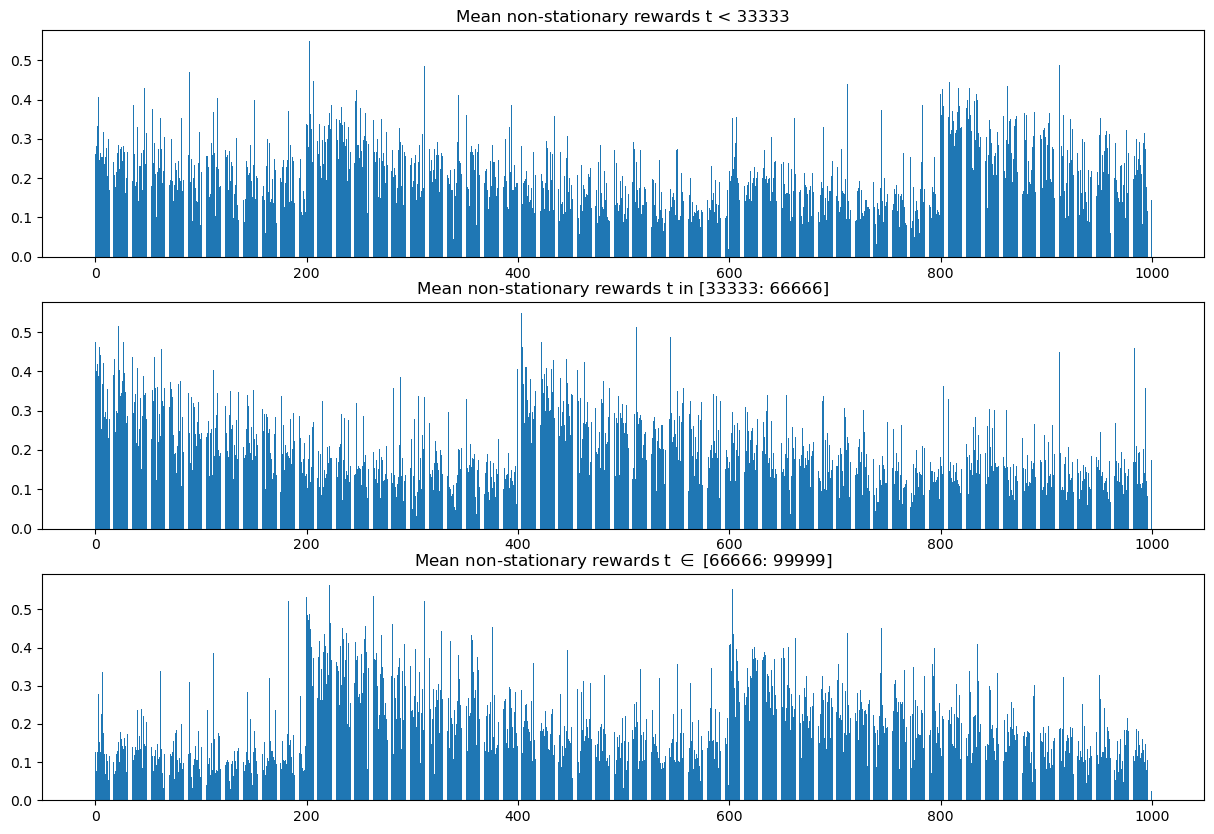

In [15]:
fig, axs = plt.subplots(3,1, figsize=(15, 10))
axs[0].bar(list(range(1000,)), np.mean(nonst_reward_vecs[:int(times/3)], axis=0))
axs[0].set_title(f'Mean non-stationary rewards t < {int(times/3)}')

axs[1].bar(list(range(1000,)), np.mean(nonst_reward_vecs[int(times/3):2*(int(times/3))], axis=0))
axs[1].set_title(fr'Mean non-stationary rewards t in [{int(times/3)}: {2*int(times/3)}]')

axs[2].bar(list(range(1000,)), np.mean(nonst_reward_vecs[2*(int(times/3)): 3*(int(times/3))], axis=0))
axs[2].set_title(fr'Mean non-stationary rewards t $\in$ [{2* int(times/3)}: {3*int(times/3)}]')
plt.show()

### Run evaluation

#### Define policies

In [16]:
ctx_dim = 120


policies = {
    # Tuned
    'LinearTS': LinearTS(context_dimension=ctx_dim, nu=0.3, seed=seed),
    'LinUCB': LinUCB(context_dimension=ctx_dim, alpha=0.9),
    'EGreedy': EGreedy(epsilon=0.001),
    'DLinTS': DLinTS(context_dimension=ctx_dim, gamma=0.999, a=0.2,  seed=seed),
    'CBRAP d=6': CBRAP(context_dimension=ctx_dim, red_dim=6, alpha=0.3),
    'CBRAP d=12': CBRAP(context_dimension=ctx_dim, red_dim=12, alpha=0.7),
    'CBRAP d=24': CBRAP(context_dimension=ctx_dim, red_dim=24, alpha=0.5),
    'BCMAB-RP d=6': BCMAB_RP(context_dimension=ctx_dim, red_dim=6, gamma=0.99, a=0.1, seed=seed)
    'BCMAB-RP d=12': BCMAB_RP(context_dimension=ctx_dim, red_dim=12, gamma=0.99, a=0.1, seed=seed)
    'Random': RandomPolicy(),
    # Not tuned
#     'BCMABRP': BCMABRP(context_dimension=ctx_dim, red_dim=red_dim, reduct_matrix=reduct_matrix, nu=0.65, seed=seed),
#     'CBRAP': CBRAP(context_dimension=ctx_dim, red_dim=red_dim, reduct_matrix=reduct_matrix, alpha=0.5),
    
}

In [17]:
results = {'reward': {}, 'ndcg': {}}
for p_name, policy in policies.items():
    start_ts = time.time()

    reward, ndcg = evaluate_policy(
        policy, times, dataset, nonstationarity_function=evaluation_nonstationarity_function
    )
    results['reward'][p_name] = reward
    results['ndcg'][p_name] = ndcg
    print(f"Total reward of {p_name} is {reward[-1][0]}")
    print(f"Total time of {p_name} is {datetime.timedelta(seconds=time.time() - start_ts)}")

Using evaluation dataset
First user in exp from 2008-10-29 03:36:53
Last user in exp from 2009-01-05 05:52:22
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
Total reward of LinearTS is 54594.0
Total time of LinearTS is 0:15:03.815919
Using evaluation dataset
First user in exp from 2008-10-29 03:36:53
Last user in exp from 2009-01-05 05:52:22
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
Total reward of LinUCB is 60784.0
Total time of LinUCB is 0:31:32.426103
Using evaluation dataset
First user in exp from 2008-10-29 03:36:53
Last user in exp from 2009-01-05 05:52:22
0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
70000
75000
80000
85000
90000
95000
Total reward of EGreedy is 34524.0
Total time of EGreedy is 0:05:58.603095
Using evaluation dataset
First user in exp from 2008-10-29 03:36:53
Last user in exp from 2009-01-05

### Plot results

In [43]:
def plot_ctrs_or_rewards(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    N = 10
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
            max_vline=max(max_vline, max(ctr))
        else:
            to_plot = rewards

            max_vline=max(max_vline, max(rewards))
            
        ax.plot(to_plot[N:], label=label)
        
    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.65
    )    
     
    extraticks = change_points
    plt.xticks(extraticks, rotation=20)
#     plt.yticks(fontsize=25)
    
    ax.set_xlabel('Trial')
    ax.set_ylabel(f'{plot_type}')

    plt.legend();
    plt.show();

In [44]:
def plot_ndcg(cumulative_ndcg_dict):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
    
    N = 10
    
    cumulative_ndcg_list = sorted(
        [
            (l,r) for l, r in cumulative_ndcg_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    for label, cumulative_ndcg in cumulative_ndcg_list:
        times = (range(1, len(cumulative_ndcg)+1))
        average_cumulative_ndcg = [cn/t for cn,t in zip(cumulative_ndcg, times)]
        ax.plot(average_cumulative_ndcg[N:], label=label)
        
    ax.set_xlabel('Trial')
    ax.set_ylabel('Average Cumulative NDCG@5')
    ax.set_title('Average Cumulative NDCG@5 on MovieLens')

    plt.legend();
    plt.show();

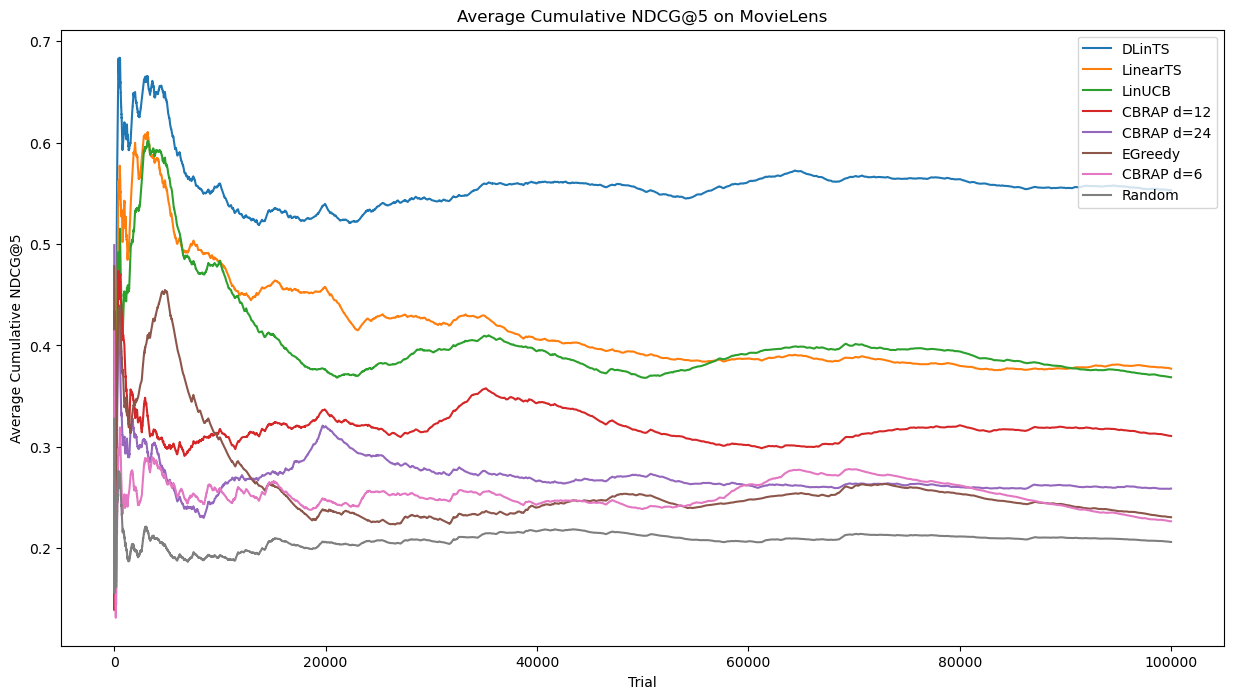

In [45]:
plot_ndcg(results['ndcg'])

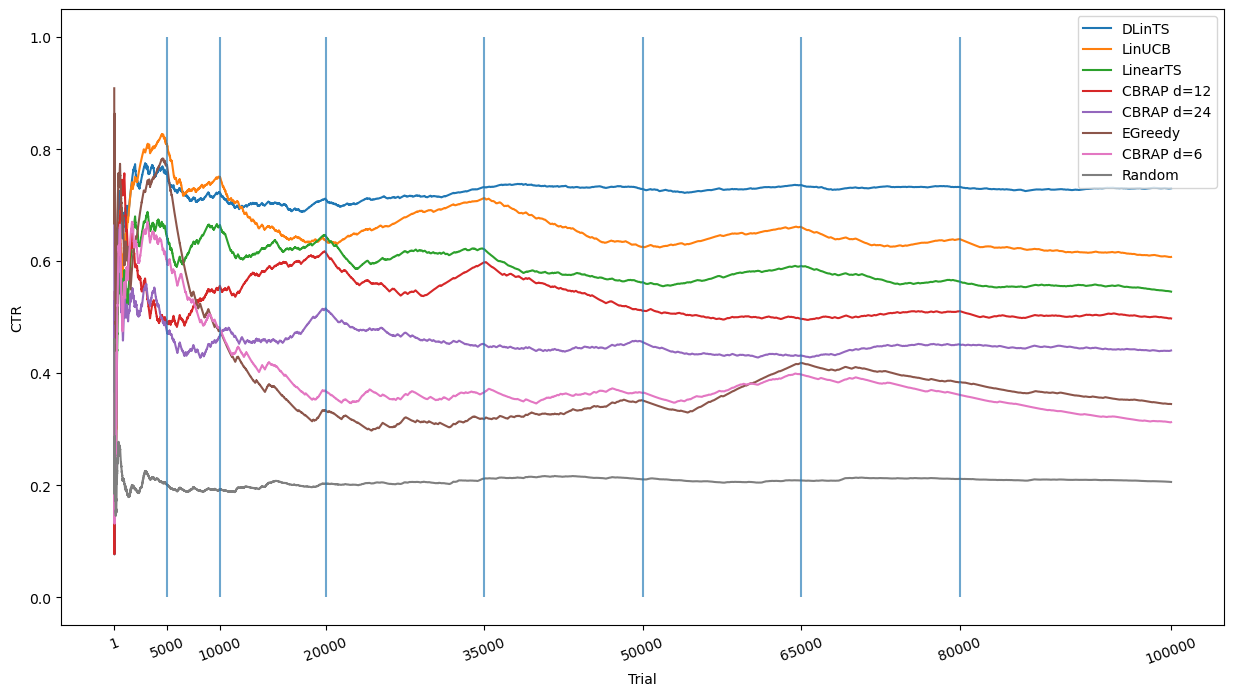

In [46]:
plot_ctrs_or_rewards(results['reward'], 'CTR', CHAGNE_POINTS)

In [47]:
print(f"Total time is {datetime.timedelta(seconds=time.time() - total_start_ts)}")

Total time is 10:21:15.550575


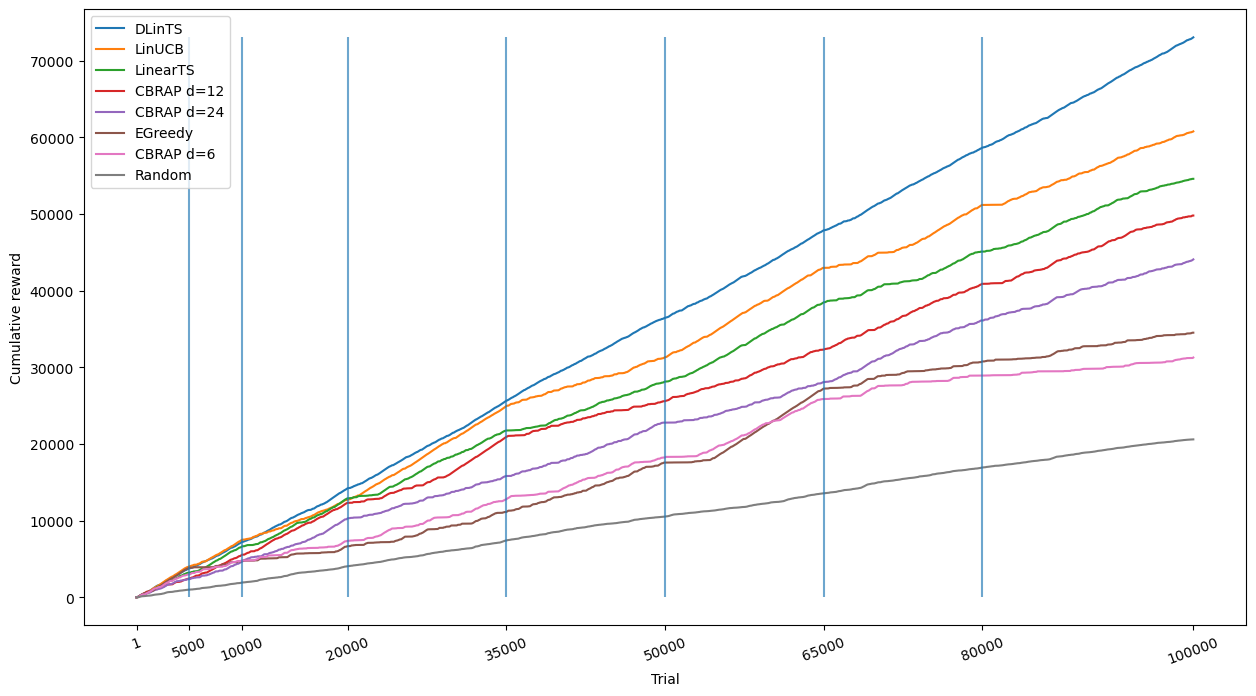

In [48]:
plot_ctrs_or_rewards(results['reward'], 'Cumulative reward', CHAGNE_POINTS)

In [28]:
results['reward']['LinUCB'][-1]

array([60784.])

In [29]:
results['reward']['LinearTS'][-1]

array([54594.])

In [30]:
# Change points : reward at 100,000
# shift by 0.4
[1, 10000, 20000, 50000, 80000, 100000] : 67273
[1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 100000] : 60784
[1, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000]: 69369
[1, 10000, 20000, 30000, 50000, 70000, 80000, 90000, 100000]    : 68882
    
# 0.2
[1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 100000] : 70379
    
# 0.5
[1, 5000, 10000, 20000, 35000, 50000, 65000, 80000, 100000] : 68210

SyntaxError: only single target (not list) can be annotated (1181864697.py, line 3)

In [39]:
def plot_ctrs_or_rewards_new(reward_dict, plot_type, change_points):
    if plot_type not in {'CTR', 'Cumulative reward'}:
        raise ValueError("plot_type should be CTR or Cumulative reward")
        
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'blue'),
        1: ('>', 'g'),
        2: ('d','m'),
        3: ('<','goldenrod'),
        4: ('s','r'),
        5: ('o','dodgerblue'),
        6: ('^', 'k'),
        7: ('x', 'cyan'),
        8: ('>', 'forestgreen'),
        9: ('d', 'darkmagenta'),
        10: ('<', 'darkgoldenrod'),
    }
    
    N = 10
    
    sorted_reward_list = sorted(
        [
            (l,r) for l, r in reward_dict.items()
        ],
        key=lambda x: x[1][-1],
        reverse=True,
    )
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline = 0
    for ind, (label, reward) in enumerate(sorted_reward_list):
        times = (range(1, len(reward)+1))
        
        rewards = [r for r,t in zip(reward, times)]
        ctr = [r/t for r,t in zip(reward, times)]
        if plot_type == 'CTR':
            to_plot = ctr
            max_vline=max(max_vline, max(ctr))
        else:
            to_plot = rewards

            max_vline=max(max_vline, max(rewards))
            
        mark, color = ind_to_params[ind]
        ax.plot(to_plot[N:], label=label, linestyle=':',
            marker=mark, markevery=7500, markersize=11, markeredgewidth=2.5,
            fillstyle='none', color=color,
            linewidth=4.0,
        )
        

    reward_change_points = change_points[1:-1]
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, alpha=0.65
    )    
    
            
    extraticks = change_points
    plt.xticks(extraticks, rotation=20, fontsize=25)
    plt.yticks(fontsize=25)
    
    ax.set_xlabel('Trial', fontsize=38)
    ax.set_ylabel(f'{plot_type}', fontsize=38)
#     ax.set_title(f'{plot_type} on MovieLens')

    plt.legend(prop={'size': 24}, ncol=1);
    plt.show();

In [ ]:
"DLinTS (lambda=1, gamma=0.9999, a=0.4)" 18986.0
"DLinTS (lambda=1, gamma=0.999, a=0.1)", 20016.0
"DLinTS (lambda=1, gamma=0.99, a=0.1)", 20780.333333333332
"DLinTS (lambda=1, gamma=0.9, a=0.1)" 20364.666666666668